# 5.3  Using a pretrained convnet

A pretrained network --> is a saved network that was previously
trained on a large dataset.
#####  1. Feature extraction
#####  2. Fine-tuning a pretrained convnet

## Selecting optimal Convnet architectures

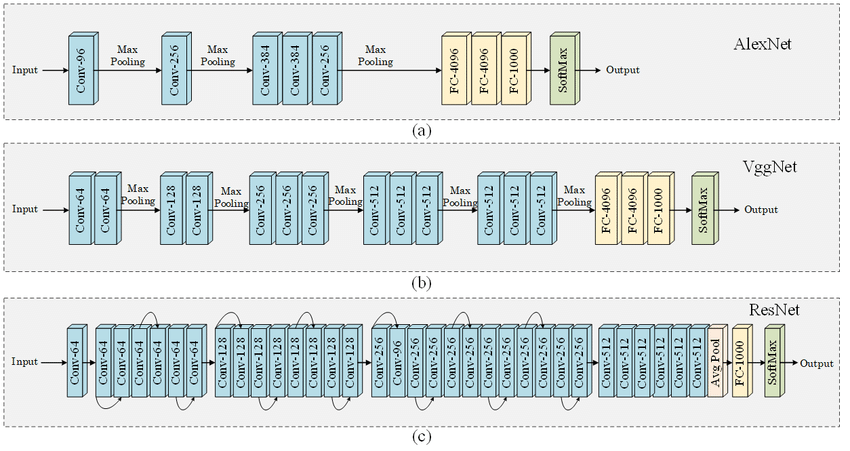

### Applying use  VGG16 architecture
 - it’s a simple and widely used convnet architecture for ImageNet
 
 - other keras pre trained models https://keras.io/api/applications/
 

 
 
 # 1. Feature extraction
 - Using the representations learned by a previous network to extract interesting features from new samples
 - Run the features through a new classifier, which is trained from scratch
 
 #### Why only reuse the convolutional base?
 - consists of more generic features that can be reused


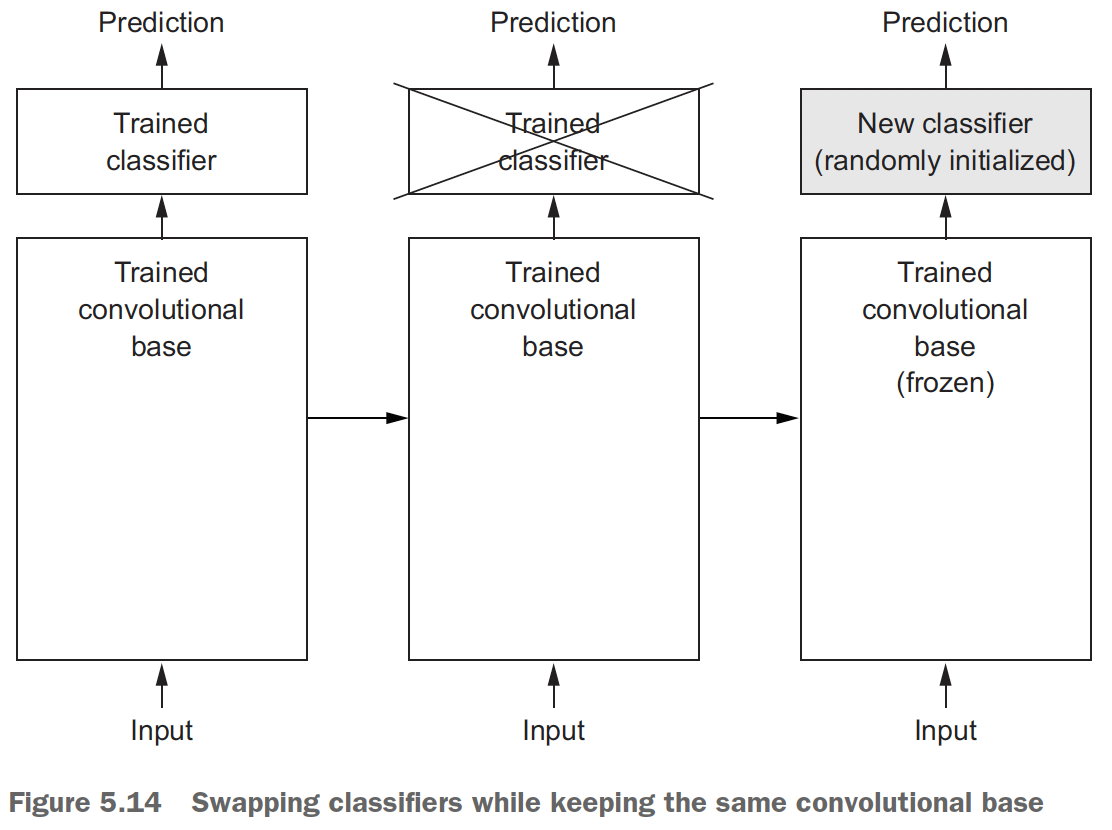

## Instantiating the VGG16 convolutional base
https://keras.io/api/applications/vgg/#vgg16-function
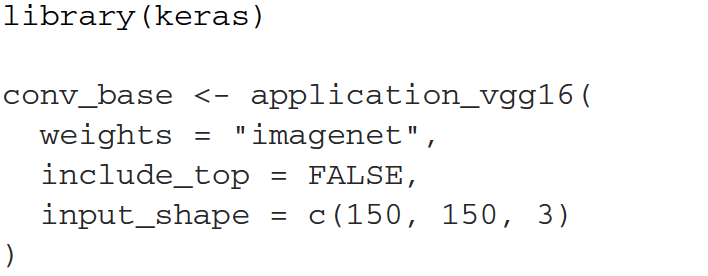

In [14]:
from keras.applications import VGG16

conv_base = VGG16(
                weights='imagenet',# the weight checkpoint from which to initialize the model.
                include_top=False, #including (or not) the densely connected layers 
                input_shape=(150, 150, 3)) #shape of the image tensors to feed the network

## The architecture of the VGG16 convolutional base

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### There are two ways we could proceed with feature extraction
###### A) Fast way
- Run the convolutional base once over our dataset
- Save its output to a numpy array
- Use the numpy array as input to a standalone densely connected classifier

###### B) Slower  way
- Extend convolutional base by adding Dense layers on top
- This will allow us to use data augmentation



### A) FAST FEATURE EXTRACTION 
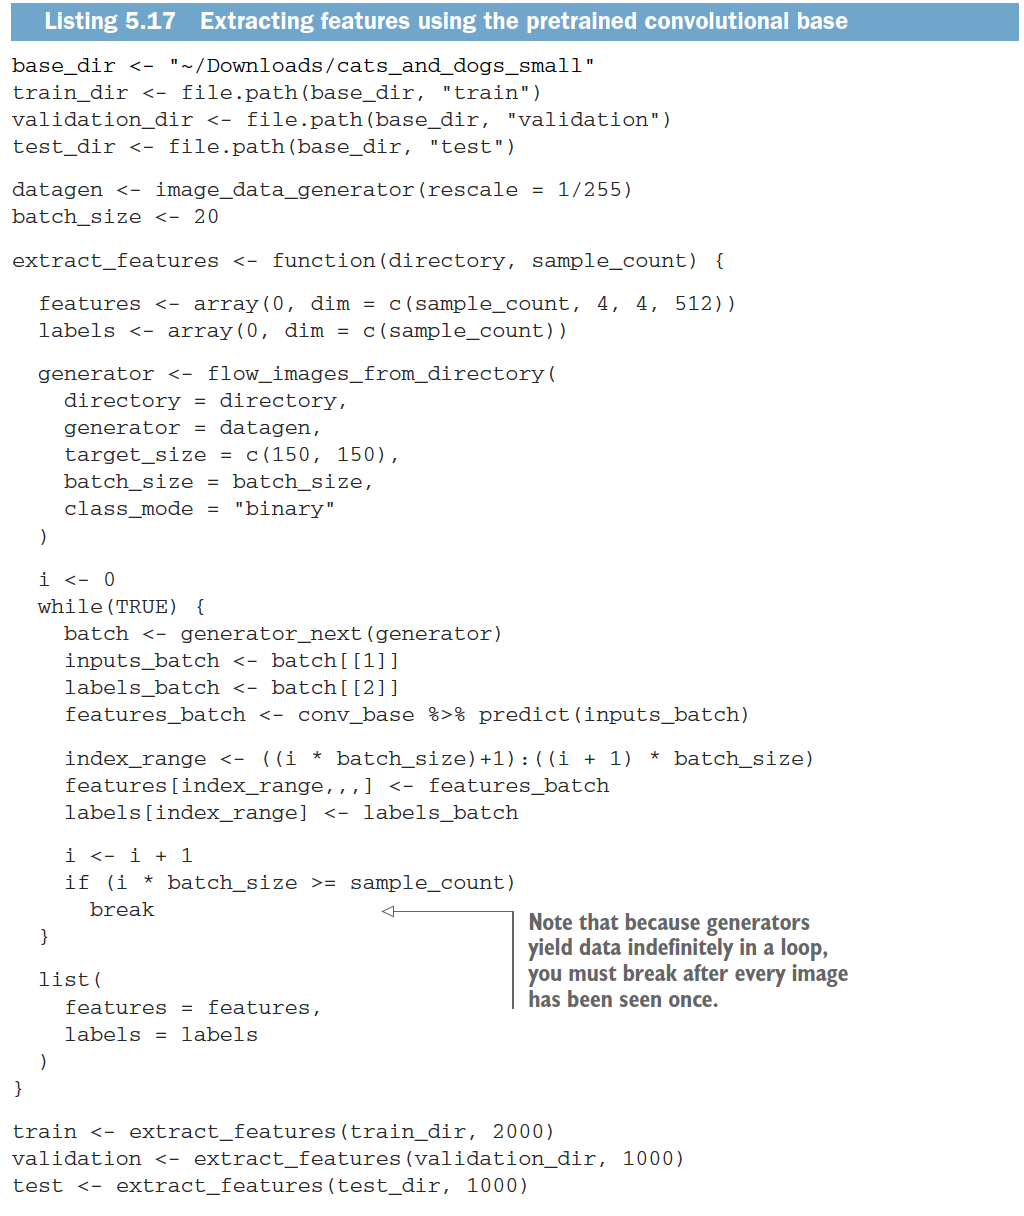

In [10]:
import os 
import shutil
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'dogs-vs-cats/new/train/'
validation_dir = 'dogs-vs-cats/new/validation/'
test_dir = 'dogs-vs-cats/new/test/'



datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Defining and training the densely connected classifier

- The extracted features shape (samples, 4, 4, 512) 
- Flatten them to (samples, 8192)

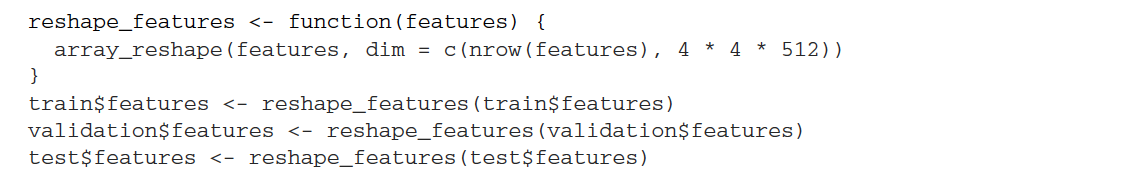
<br>
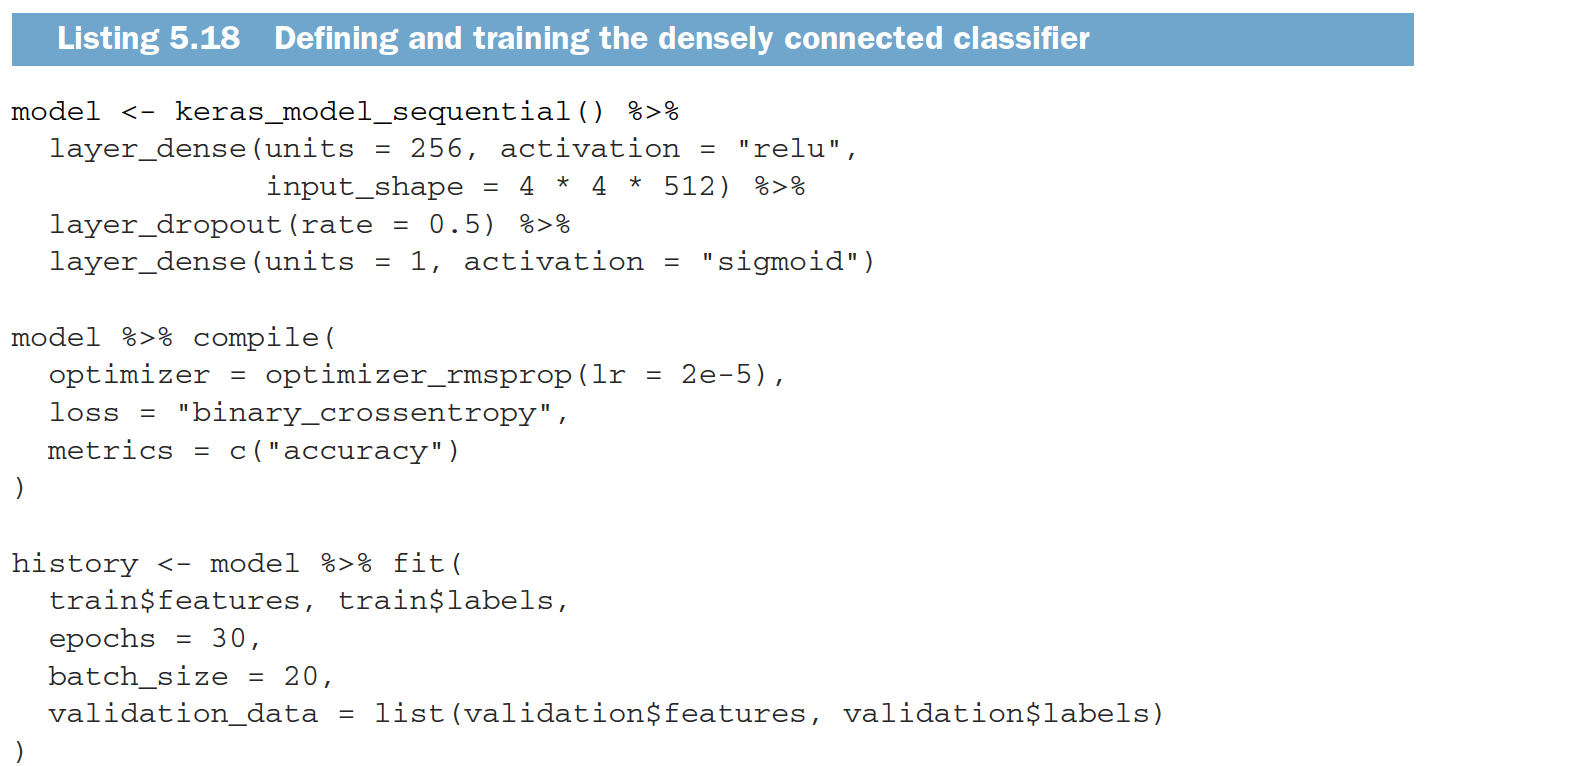

In [17]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])

history = model.fit(train_features, train_labels,
            epochs=30,
            batch_size=20,
            validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 19ms/step - loss: 0.6343 - acc: 0.6532 - val_loss: 0.4352 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 2s 17ms/step - loss: 0.4385 - acc: 0.7946 - val_loss: 0.3718 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3782 - acc: 0.8444 - val_loss: 0.3262 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3089 - acc: 0.8751 - val_loss: 0.3036 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2721 - acc: 0.8960 - val_loss: 0.2938 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2512 - acc: 0.9074 - val_loss: 0.2929 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2692 - acc: 0.8977 - val_loss: 0.2681 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 2s 17ms/step - 

### Plotting the results

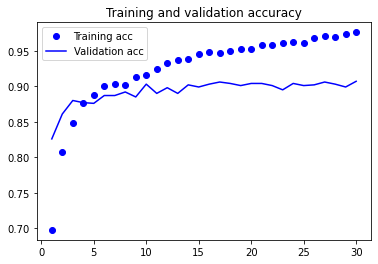

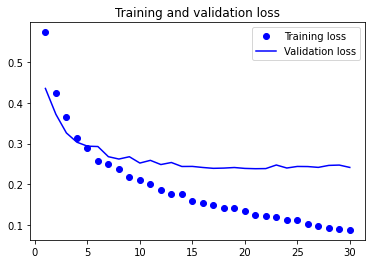

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

 ### B) FEATURE EXTRACTION WITH DATA AUGMENTATION
 
 ##### Computational expensive - use GPU
 
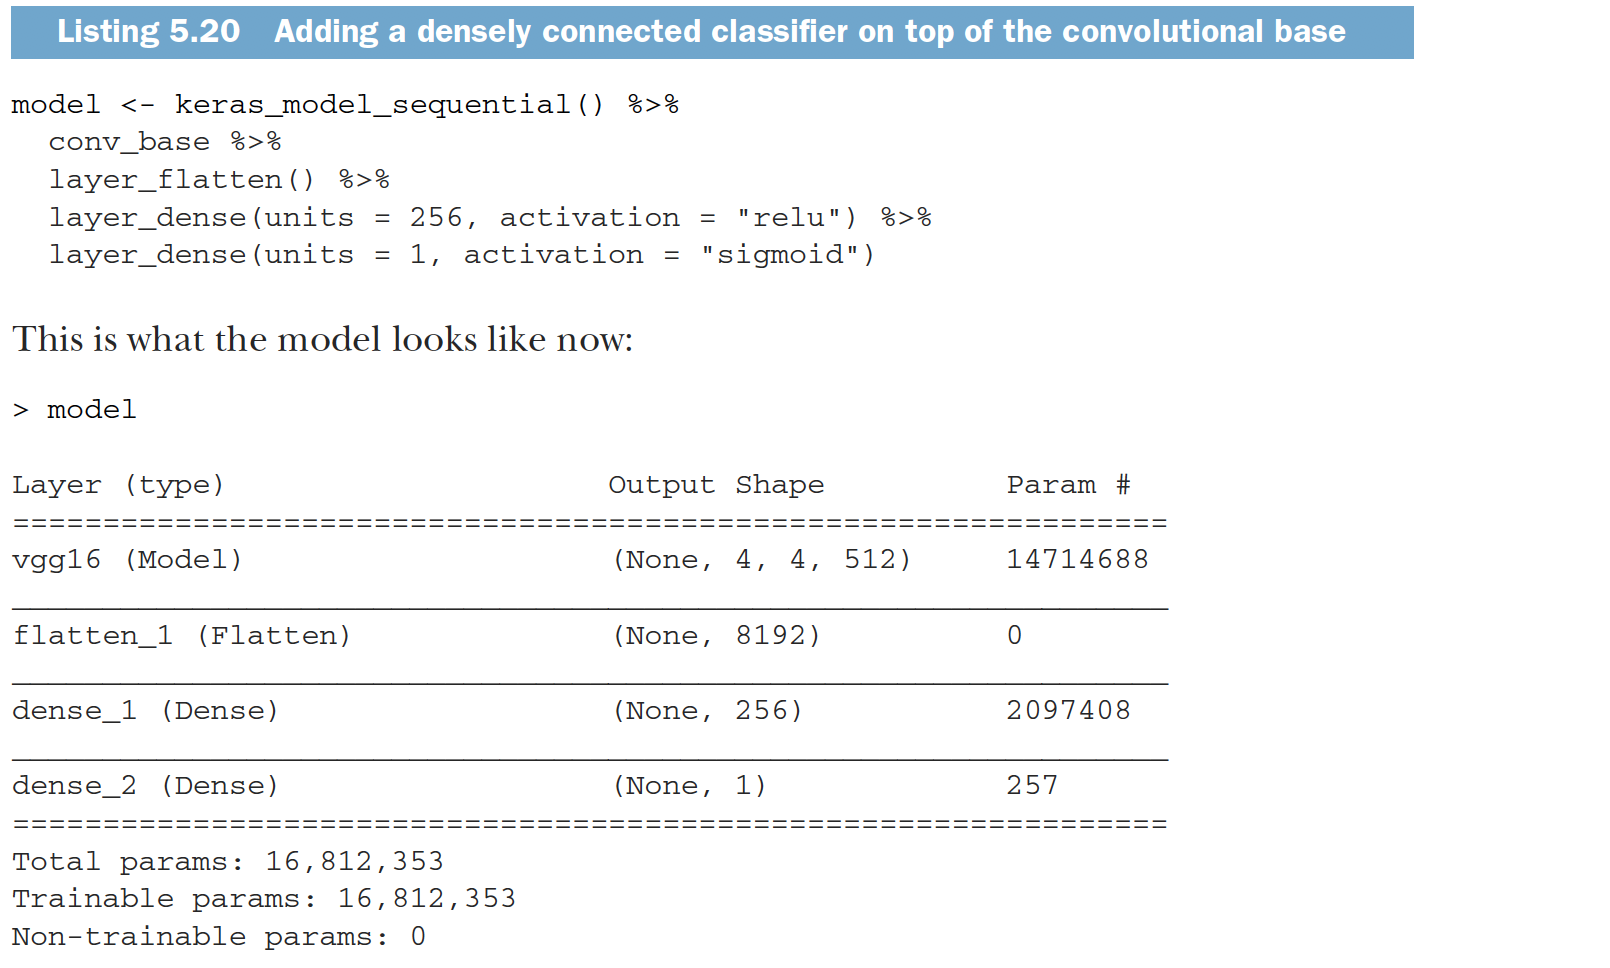

### Freezing a layer or set of layers
- preventing their weights from beingupdated during training.
- In Keras, you freeze a network by setting its 'trainable' attribute to 'False' <br>
> freeze_weights(conv_base)

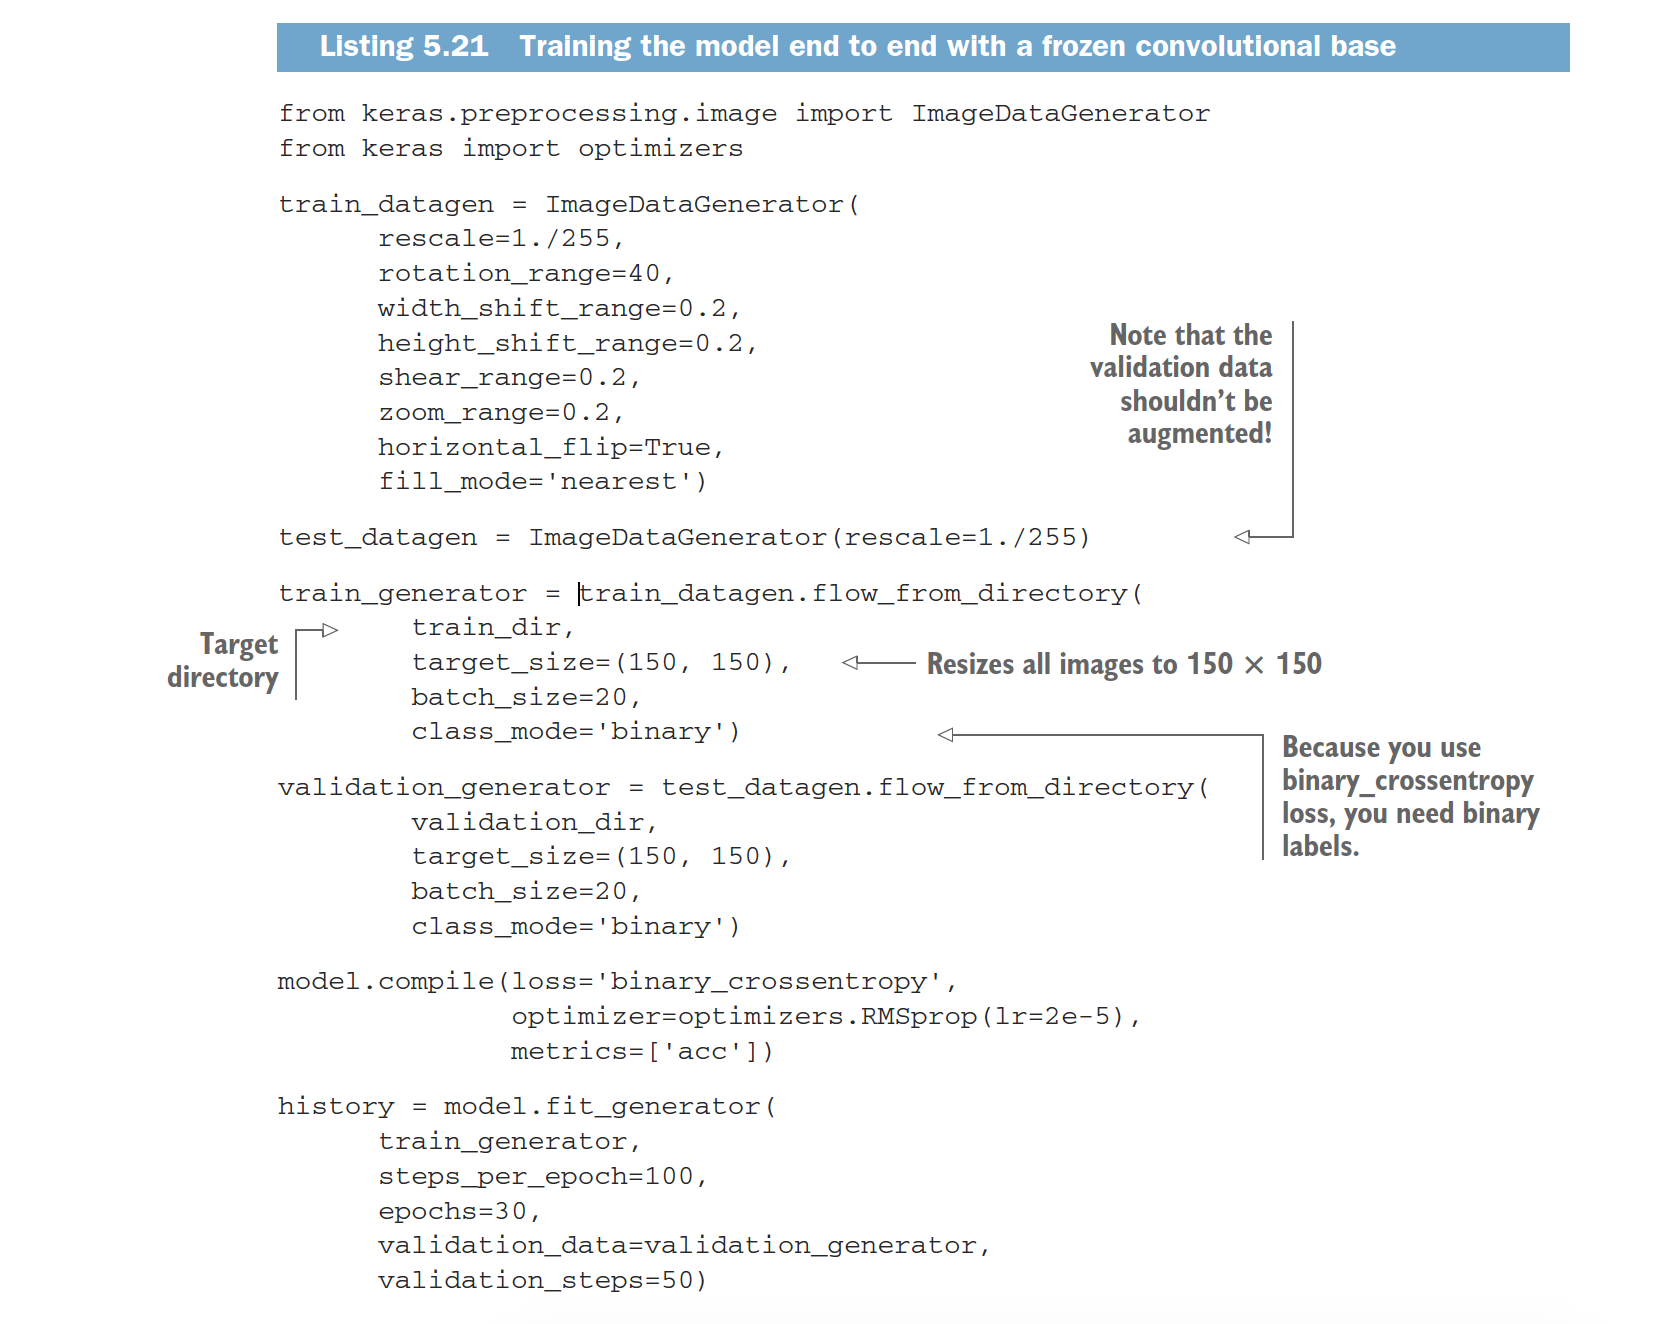

# 5.3  Using a pretrained convnet

# 2. Fine-tuning

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base 
 
 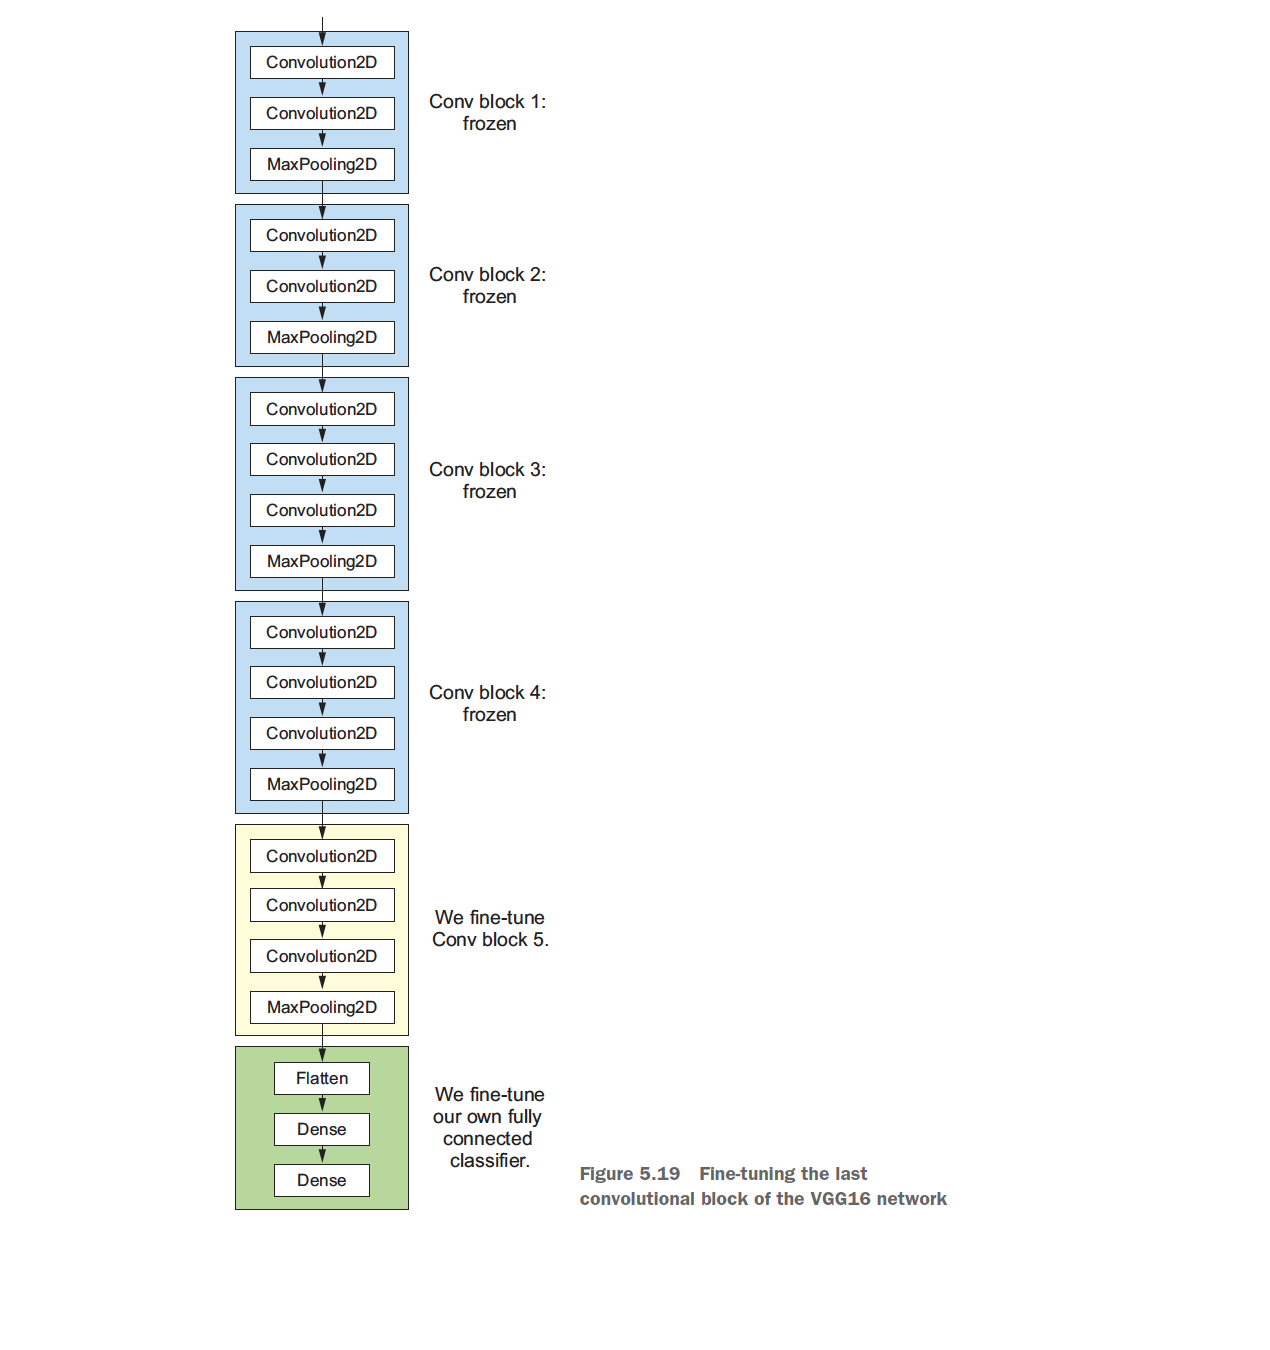

### steps for fine-tuning a network
> 1. Add your custom network on top of an already-trained base network.
> 2. Freeze the base network.
> 3. Train the part you added.
> 4. Unfreeze some layers in the base network.
> 5. Jointly train both these layers and the part you
added.

## Unfreezing some layers in the base network.


##### Why not fine-tune all layers?
- Earlier layers in the convolutional base encode more-generic, reusable features
- The more parameters you’re training, the more you’re at risk of overfitting

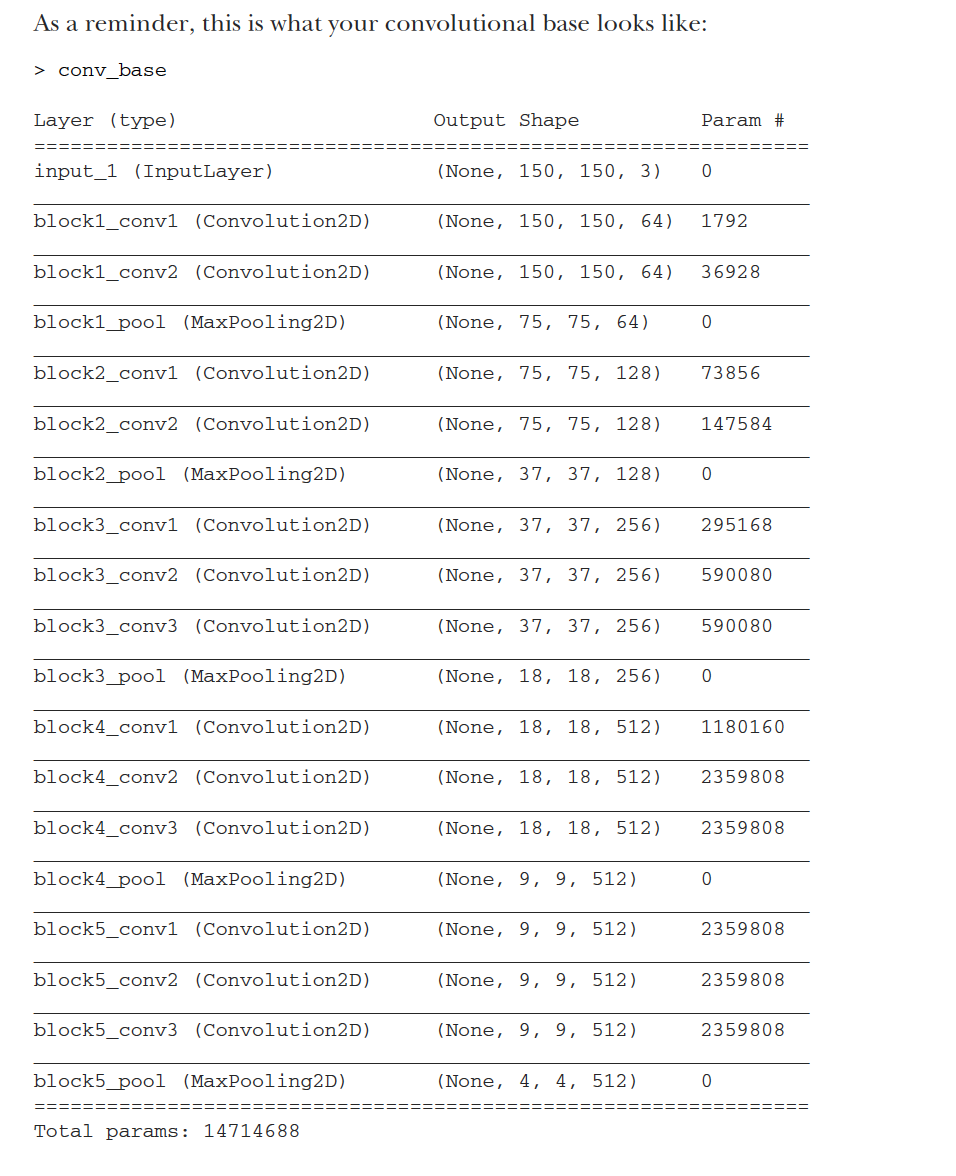

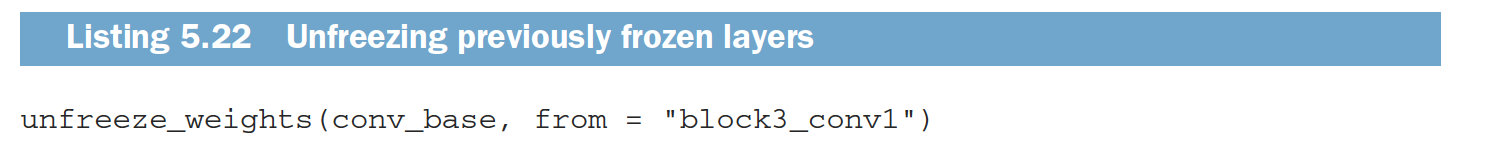

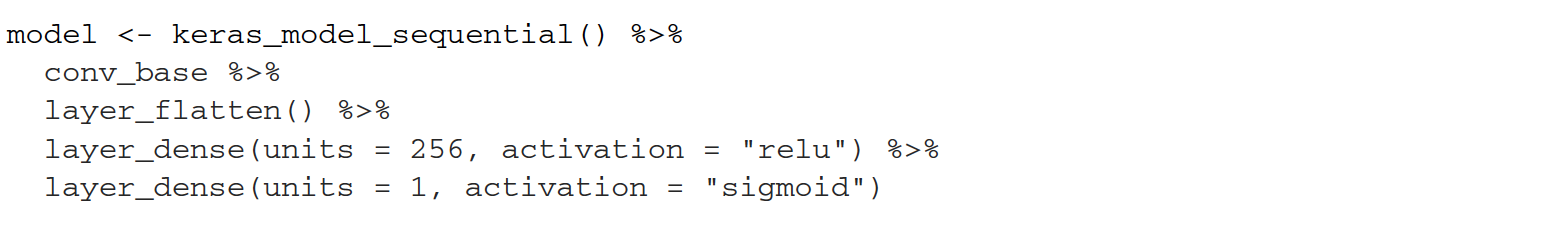

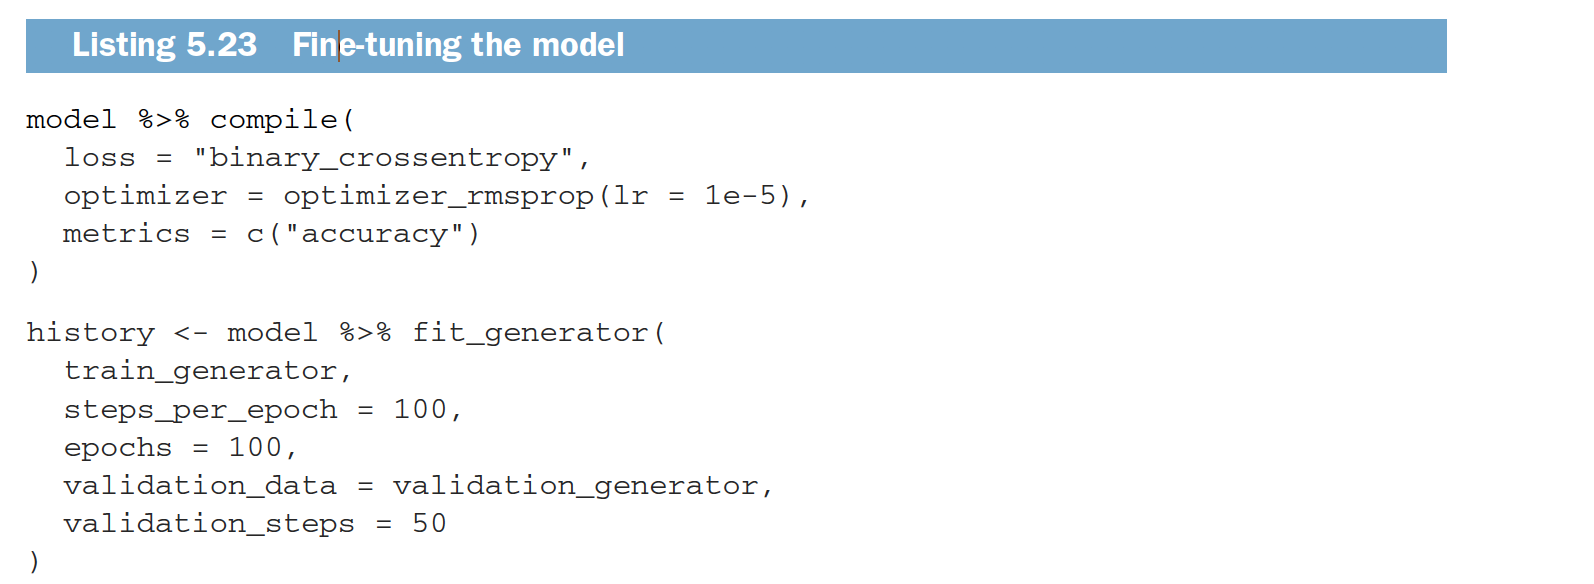

### Important to note
- Use very low learning rate to limit the magnitude of the modifications you make to the representations of the  layers you’re fine-tuning.


In [24]:
from keras import models
from keras import layers

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/Users/dativabella/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 208s 2s/step - loss: 0.5650 - acc: 0.7039 - val_loss: 0.2767 - val_acc: 0.8850
Epoch 2/30
100/100 [==============================] - 217s 2s/step - loss: 0.2229 - acc: 0.9106 - val_loss: 0.2347 - val_acc: 0.9010
Epoch 3/30
100/100 [==============================] - 226s 2s/step - loss: 0.1354 - acc: 0.9620 - val_loss: 0.2076 - val_acc: 0.9130
Epoch 4/30
100/100 [==============================] - 220s 2s/step - loss: 0.0850 - acc: 0.9780 - val_loss: 0.1895 - val_acc: 0.9180
Epoch 5/30
100/100 [==============================] - 264s 3s/step - loss: 0.0502 - acc: 0.9884 - val_loss: 0.2089 - val_acc: 0.9140
Epoch 6/30
100/100 [==============================] - 223s 2s/step - loss: 0.0361 - acc: 0.9934 - val_loss: 0.1916 - val_acc: 0.9210
Epoch 7/30
100/100 [==============================] - 240s 2s/step - loss: 0.0178 - acc: 0.9993 - val_loss: 0.2471 - val_acc: 0.9100
Epoch 8/30
100/100 [==============================] - ETA: 0s - loss:

KeyboardInterrupt: 

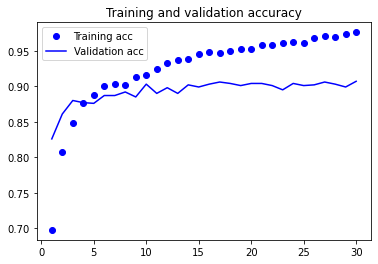

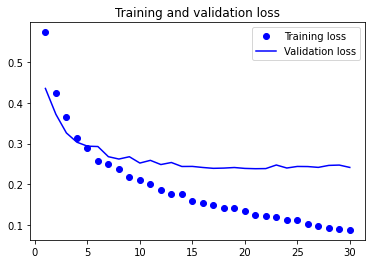

In [25]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

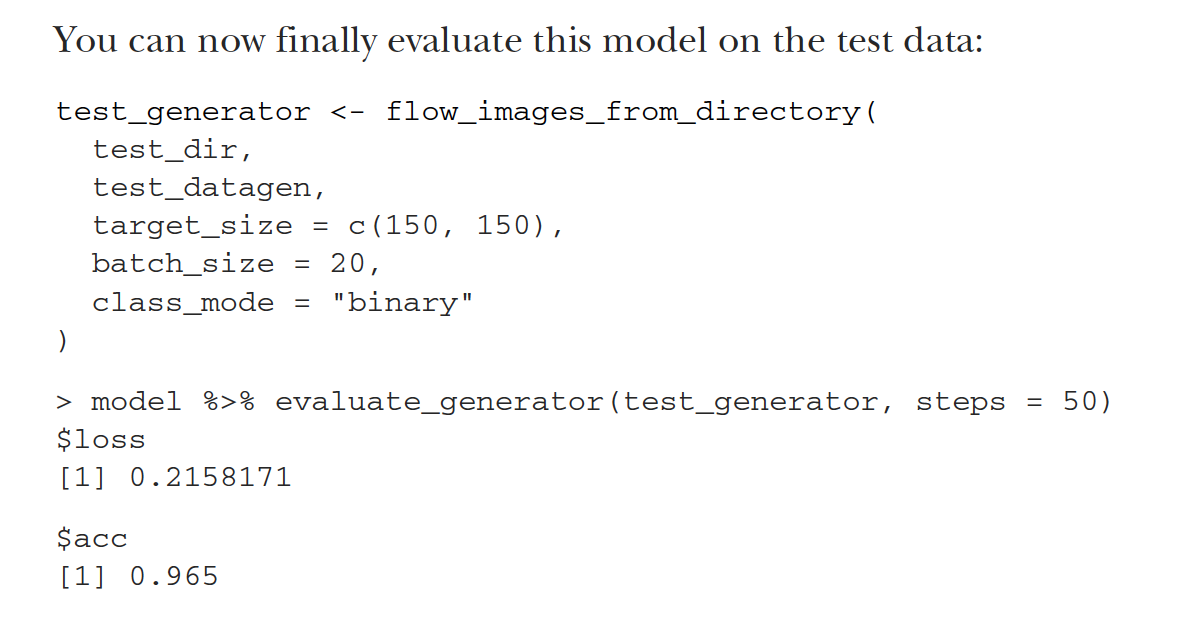